# DIVE INTO CODE 卒業課題

卒業課題テーマとしてKaggle（TReNDS Neuroimaging）を選択。  

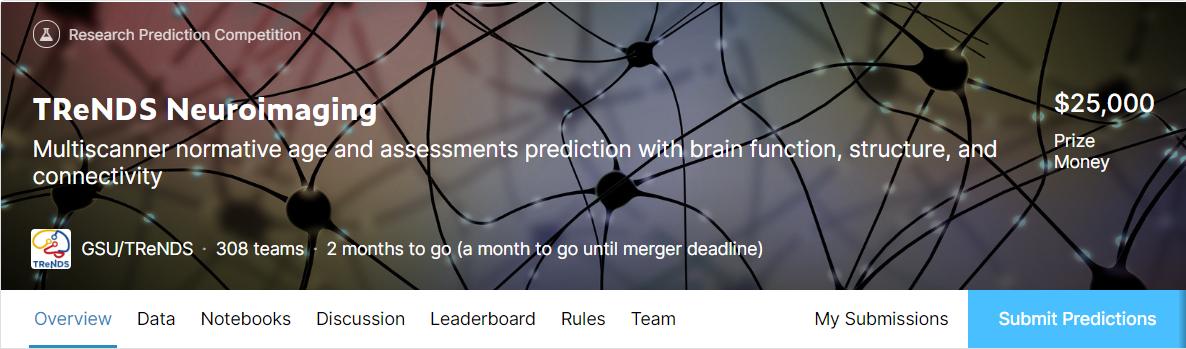

In [20]:
Image("trends_1.png")

### ＜概要＞
- Translational Research in Neuroimaging and Data Science ; TReNDS  
ジョージア州立大学、ジョージア工科大学、エモリ―大学の3機関からなり、神経画像を通して脳の健康に関する研究を推進している組織。
- コンペの内容  
脳MRI画像の特徴量から、年齢と4つの指数を予測する。  
（既に他のデータサイエンティストによって見出された特徴量を使用し、その有用性を検証）

### ＜目的＞
1. 特徴量として与えられている指標の重要性を検証
…脳の構造は複雑で検査機器の間にも違いがあり、神経画像研究の推進のためには一般化された効果的なアプローチが必要である。
2. 基礎研究での知見を臨床へ応用する
…研究成果の再現性・有効性を検証し、神経画像研究の専門家が画像と機能の関係を特定する支援を行う。
3. 脳年齢と実年齢の乖離は、神経疾患との関連が示唆されている  
…年齢と比較し脳の老化が進んで見える場合には、Alzheimer型認知症の有病率が高い

### ＜選定理由＞
- プロダクト作成≦データ分析技術の習熟
- データ取得が容易、スコアでの評価が可能（医療データは取得が難しい）
- 自分の経歴に関連する領域

### ＜データ＞
【特徴量】
- loading.csv（信号強度）
…通常の脳MRIにおける、脳の各領域の灰白質の重み
- fnc.csv（相関係数）
…機能的MRIにおける、53の機能的ネットワーク同士の相関係数

いずれも独立主成分分析（independent component analysis;ICA）で求めたもの

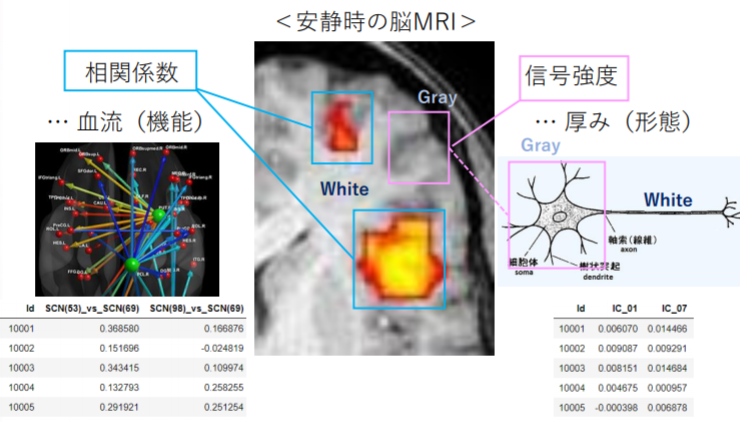

In [1]:
Image("trends_4.png")

【予測対象】
- train_scores.csv
…年齢と4つの指標（指標が何を意味しているかは不明）

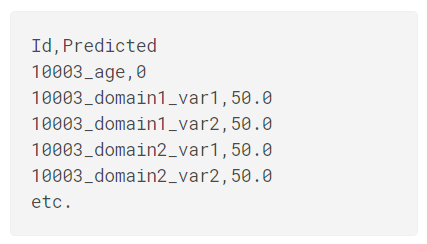

In [6]:
Image("trends_3.png")

【補足】  
データは2つの機器から収集（site1/site2）されたが、一方の機器のデータ（site2）は全てテストセットに割り当てられている。データ数はsite1＞site2だが、具体的な数はコンペ終了まで明らかにされない。site2データの一部はIDが明かされており、学習モデルは機器の違いによるバイアスに左右されない、一般的な性能が期待されている。

### ＜評価＞  

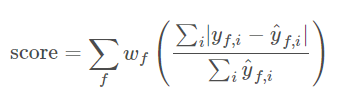

In [5]:
Image("trends_2.png")

$w_f$ : 各変数の予測値に対する重み  
$y_{f,i}$ : 各変数の真値  
$\hat{y}_{f,i}$ : 各変数の予測値  
  
  
- 評価指標は重み付きかつ特徴量ごとにスケールされた絶対誤差
- 重みは年齢が0.3で、残り4つの指標が0.7÷4＝0.175

### ＜期限＞  
- 2020/06/22 : 参加受付、チーム編成受付期限
- 2020/06/29 : 最終提出期限

### ＜データの詳細＞

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
import missingno as msno
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
import keras


Bad key "text.kerning_factor" on line 4 in
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


### 0. target

In [2]:
# 予測対象の訓練データ
df_train = pd.read_csv('train_scores.csv')
display(df_train.head())
print('size : {}'.format(np.shape(df_train)))

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421


size : (5877, 6)


In [16]:
# 年齢データの内訳
np.unique(df_train['age'].values, return_counts=True)

(array([14.25726522, 17.22458014, 21.74381885, 25.39336169, 28.44274169,
        30.99738266, 33.40469072, 35.3265819 , 36.96117389, 38.61738057,
        40.12936066, 41.51720254, 42.94115369, 44.42390642, 45.8882136 ,
        47.47020319, 48.94875626, 50.42774666, 51.99651429, 53.5838048 ,
        55.45697773, 57.43607707, 59.58085067, 61.81138167, 64.20310694,
        66.53262952, 68.82092847, 71.41301813, 73.87045558, 76.53864269,
        79.41543791, 81.9080382 , 84.49111251]),
 array([ 17,  45,  90, 120, 144, 162, 186, 186, 168, 191, 186, 198, 218,
        220, 243, 245, 254, 248, 257, 285, 280, 337, 305, 249, 243, 210,
        158, 144, 109,  80,  57,  23,  19], dtype=int64))

- 年齢は各被験者の真値ではなく、上記の33個のいずれかに調整されている
- 被験者数は50代が最も多い


PandasProfilingを使用し、データの分布を確認（putfileのHTMLに出力）

In [8]:
profile_train = ProfileReport(df_train)
profile_train.to_file("putfile_train.html")

- 各変数は正規分布のような釣り鐘型の分布
- 年齢以外の変数は、やや左に裾が長い
- 相関係数行列をみると、age/dmain1_var1, age/dmain2_var1との間に弱い正の相関がありそう

### 1. sMRI

In [3]:
pd.set_option('display.max_columns', 100)
df_sMRI = pd.read_csv('loading.csv')
display(df_sMRI.head())
print('size : {}'.format(np.shape(df_sMRI)))

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,IC_04,IC_12,IC_24,IC_15,IC_13,IC_17,IC_02,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
0,10001,0.006070,0.014466,0.004136,0.000658,-0.002742,0.005033,0.016720,0.003484,0.001797,0.029223,0.007778,0.014609,0.005123,0.017628,0.045102,0.008492,0.018246,0.023711,0.009177,-0.013929,0.030696,0.010496,0.002892,-0.023235,0.022177,0.017192
1,10002,0.009087,0.009291,0.007049,-0.002076,-0.002227,0.004605,0.012277,0.002946,0.004086,0.027333,0.005419,0.006232,0.008819,0.017868,0.046214,0.003573,0.014635,0.022556,0.012004,-0.011814,0.022479,0.005739,0.002880,-0.016609,0.025543,0.014524
2,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,0.038530,0.001721,0.001985,0.012548,0.025707,0.053774,0.011670,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164
3,10004,0.004675,0.000957,0.006154,-0.000429,-0.001222,0.011755,0.013010,0.000193,0.008075,0.027787,-0.005184,0.004144,0.006837,0.016737,0.045259,0.007893,0.002658,0.022266,0.005956,-0.010595,0.024078,-0.000319,0.005866,-0.015182,0.024476,0.014760
4,10005,-0.000398,0.006878,0.009051,0.000369,0.000336,0.010679,0.010352,0.003637,0.004180,0.021058,0.000377,0.004329,0.005255,0.013587,0.040847,0.008795,0.009702,0.017257,0.005454,-0.008591,0.019416,0.000786,0.002692,-0.019814,0.017105,0.013316


size : (11754, 27)


In [11]:
profile_sMRI = ProfileReport(df_sMRI)
profile_sMRI.to_file("putfile_sMRI.html")

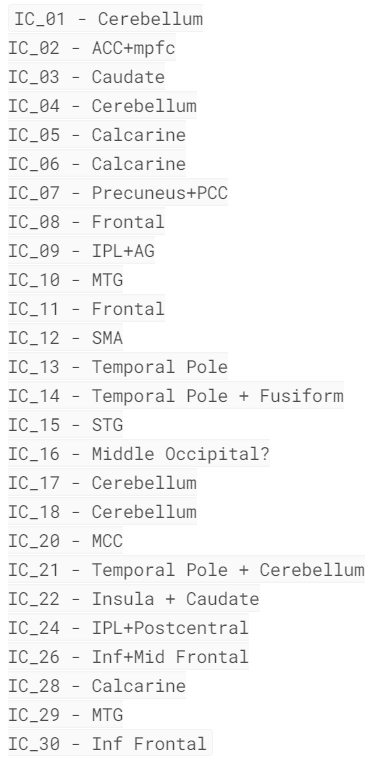

In [2]:
Image("trends_5.png")

- 脳の各領域（島皮質, 小脳など）毎の灰白質の信号データ
- 各信号は左右対象にちかい釣り鐘型の分布
- 同じ領域同士（小脳のIC_01, IC_17）は相関関係があるが、targetである年齢や変数との間には強い相関なし

### 2. fMRI

In [4]:
df_fnc = pd.read_csv('fnc.csv')
display(df_fnc.head())
print('size : {}'.format(np.shape(df_fnc)))

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),SMN(11)_vs_SCN(69),SMN(27)_vs_SCN(69),SMN(54)_vs_SCN(69),SMN(66)_vs_SCN(69),SMN(80)_vs_SCN(69),SMN(72)_vs_SCN(69),VSN(16)_vs_SCN(69),VSN(5)_vs_SCN(69),VSN(62)_vs_SCN(69),VSN(15)_vs_SCN(69),VSN(12)_vs_SCN(69),VSN(93)_vs_SCN(69),VSN(20)_vs_SCN(69),VSN(8)_vs_SCN(69),VSN(77)_vs_SCN(69),CON(68)_vs_SCN(69),CON(33)_vs_SCN(69),CON(43)_vs_SCN(69),CON(70)_vs_SCN(69),CON(61)_vs_SCN(69),CON(55)_vs_SCN(69),CON(63)_vs_SCN(69),CON(79)_vs_SCN(69),CON(84)_vs_SCN(69),CON(96)_vs_SCN(69),CON(88)_vs_SCN(69),CON(48)_vs_SCN(69),CON(81)_vs_SCN(69),CON(37)_vs_SCN(69),CON(67)_vs_SCN(69),CON(38)_vs_SCN(69),CON(83)_vs_SCN(69),DMN(32)_vs_SCN(69),DMN(40)_vs_SCN(69),DMN(23)_vs_SCN(69),DMN(71)_vs_SCN(69),DMN(17)_vs_SCN(69),DMN(51)_vs_SCN(69),DMN(94)_vs_SCN(69),CBN(13)_vs_SCN(69),...,DMN(94)_vs_DMN(32),CBN(13)_vs_DMN(32),CBN(18)_vs_DMN(32),CBN(4)_vs_DMN(32),CBN(7)_vs_DMN(32),DMN(23)_vs_DMN(40),DMN(71)_vs_DMN(40),DMN(17)_vs_DMN(40),DMN(51)_vs_DMN(40),DMN(94)_vs_DMN(40),CBN(13)_vs_DMN(40),CBN(18)_vs_DMN(40),CBN(4)_vs_DMN(40),CBN(7)_vs_DMN(40),DMN(71)_vs_DMN(23),DMN(17)_vs_DMN(23),DMN(51)_vs_DMN(23),DMN(94)_vs_DMN(23),CBN(13)_vs_DMN(23),CBN(18)_vs_DMN(23),CBN(4)_vs_DMN(23),CBN(7)_vs_DMN(23),DMN(17)_vs_DMN(71),DMN(51)_vs_DMN(71),DMN(94)_vs_DMN(71),CBN(13)_vs_DMN(71),CBN(18)_vs_DMN(71),CBN(4)_vs_DMN(71),CBN(7)_vs_DMN(71),DMN(51)_vs_DMN(17),DMN(94)_vs_DMN(17),CBN(13)_vs_DMN(17),CBN(18)_vs_DMN(17),CBN(4)_vs_DMN(17),CBN(7)_vs_DMN(17),DMN(94)_vs_DMN(51),CBN(13)_vs_DMN(51),CBN(18)_vs_DMN(51),CBN(4)_vs_DMN(51),CBN(7)_vs_DMN(51),CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,0.368580,0.166876,0.438148,0.341007,-0.186251,0.049096,0.121417,-0.174268,-0.231578,0.000947,-0.309387,-0.013269,-0.237781,-0.361850,-0.165181,-0.232689,-0.087128,-0.404605,-0.281643,-0.141046,0.169682,-0.191200,-0.175069,-0.206694,-0.231410,0.047839,0.188612,0.338715,-0.256404,0.028057,-0.224618,-0.239077,0.215035,0.011454,-0.260670,0.447783,-0.064587,0.139647,-0.104753,-0.204877,0.316565,-0.495153,0.069794,0.157164,-0.179685,0.455996,-0.438549,0.081079,-0.340220,...,0.128535,0.303497,0.162034,-0.196496,-0.298840,0.634123,0.553354,0.436383,0.286509,0.633076,-0.274189,0.060903,0.084952,-0.172911,0.425548,0.620014,0.035599,0.705913,-0.198653,0.203644,0.134927,0.041156,0.163678,0.276572,0.387289,-0.063242,0.061152,-0.049253,-0.229196,-0.228465,0.476826,-0.356746,-0.008384,0.136473,0.034347,-0.067857,0.231905,-0.043419,-0.292876,-0.451307,-0.149279,0.552841,0.131046,0.335446,0.394867,-0.042853,0.124627,-0.060712,0.515964,0.290488
1,10002,0.151696,-0.024819,0.217504,0.418072,-0.227234,-0.064052,-0.143832,-0.118116,-0.054825,0.038732,0.035640,0.041466,-0.123721,-0.111059,0.092465,-0.299313,-0.039536,-0.486443,-0.178857,-0.036421,-0.106545,-0.034260,-0.177363,-0.196084,-0.188506,-0.097829,0.162868,-0.198883,-0.199931,-0.201480,-0.296022,0.074729,-0.242173,-0.035884,-0.158039,0.361948,-0.105016,0.050577,0.050343,-0.119580,0.510545,-0.446804,-0.154972,0.137951,-0.286361,0.378998,-0.604789,-0.226727,-0.077109,...,0.118031,-0.016623,-0.111987,-0.057299,0.083966,0.555882,0.618487,0.404051,0.109458,0.794931,-0.289806,-0.297000,0.233930,-0.310834,0.415581,0.692676,-0.289636,0.593502,-0.314787,-0.320460,0.034513,-0.448188,0.210729,0.185737,0.526075,-0.055738,-0.332735,0.309354,-0.245736,-0.426153,0.326195,-0.318364,-0.378719,0.079382,-0.400562,0.039839,0.035288,-0.150326,-0.117559,-0.021944,-0.214216,-0.039792,0.143014,-0.189962,0.498373,0.444231,0.592438,0.028649,0.705524,0.248327
2,10003,0.343415,0.109974,0.741641,0.578558,-0.676446,-0.436960,-0.295663,-0.377790,-0.344963,-0.294511,-0.273254,-0.057660,-0.328309,-0.258488,0.014564,-0.295048,-0.071787,-0.413983,-0.336759,0.018994,0.292083,-0.121689,-0.052

size : (11754, 1379)


- functional MRIで与えられる、53領域の血流データ間の相関係数
- ${}_{53} C_2=1378$通りの値がある
- 53の各領域は皮質下（Sub-cortical Network：SCN）、聴覚（Auditory Network:ADN）、体性感覚・運動（Sensorimotor Network:SMN）、視覚（Visual Network:VSN）、認知（Cognitive-control Network:CON）、定常（Default-mode Network:DMN）、小脳（Cerebellar Network:CBN）にグループ分けされている


### 3. site

In [5]:
df_site = pd.read_csv('reveal_ID_site2.csv')
display(df_site.head())
print('size : {}'.format(np.shape(df_site)))

,Id
0,10012
1,10014
2,10020
3,10034
4,10059


size : (510, 1)


- 使用されたMRI機器の違いに関するデータ

### ＜EDA＞  
独自の特徴量を作成してみる。  
sMRIで与えられる信号データも、fMRIで与えられる相関係数も部位と関連があるので、解剖学的な部位毎（前頭葉,側頭葉,島皮質など）に対応する信号と相関係数を、CSV形式でExcel上に作成、以下に読み込む。

In [6]:
ICN = pd.read_csv('ICN_numbers.csv')
ICN

,ICN_number,IC
0,SCN(69),IC_03
1,SCN(53),ave
2,SCN(98),IC_22
3,SCN(99),IC_22
4,SCN(45),ave
5,ADN(21),IC_15
6,ADN(56),10+15
7,SMN(3),8+11
8,SMN(9),8+11
9,SMN(2),8+11


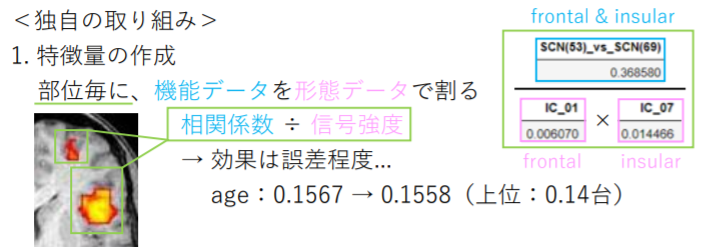

In [3]:
Image("trends_6.png")

部位ごとに、sMRIの信号データをまとめる。  
後に比をとるので、最小値を加えて全ての値を正の値へ変換する。

In [9]:
pd.set_option('display.max_columns', 100)

# 最小値（0.05）を足して正の値へ変換
df_s = df_sMRI.iloc[:, 1:]+0.05
# 側頭葉
temp = ((df_s['IC_15']+df_s['IC_10'])/2).rename('10+15')
df_s = pd.concat([df_s, temp], axis=1)
# 前頭葉
temp = ((df_s['IC_08']+df_s['IC_11'])/2).rename('8+11')
df_s = pd.concat([df_s, temp], axis=1)
# 前頭葉+頭頂葉
temp = ((df_s['IC_08']+df_s['IC_11']+df_s['IC_24'])/3).rename('8+11+24')
df_s = pd.concat([df_s, temp], axis=1)
# 鳥距溝
temp = ((df_s['IC_05']+df_s['IC_06'])/2).rename('5+6')
df_s = pd.concat([df_s, temp], axis=1)
# 帯状回
temp = ((df_s['IC_20']+df_s['IC_07'])/2).rename('7+20')
df_s = pd.concat([df_s, temp], axis=1)
# 小脳
temp = ((df_s['IC_01']+df_s['IC_04']+df_s['IC_17']+df_s['IC_18'])/4).rename('1+4+17+18')
df_s = pd.concat([df_s, temp], axis=1)
# 全体の平均
ave = np.mean(df_s, axis=1).rename('ave')
df_s = pd.concat([df_s, ave], axis=1)
# 例示
df_s.describe()

,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,IC_04,IC_12,IC_24,IC_15,IC_13,IC_17,IC_02,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14,10+15,8+11,8+11+24,5+6,7+20,1+4+17+18,ave
count,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000
mean,0.055423,0.059251,0.060635,0.051054,0.048729,0.063410,0.063749,0.051988,0.055053,0.080090,0.046443,0.056161,0.060374,0.068173,0.094103,0.057345,0.060036,0.070869,0.059754,0.041919,0.073412,0.055084,0.053595,0.035271,0.076623,0.066187,0.062062,0.066724,0.063203,0.062022,0.057168,0.071167,0.060846
std,0.004552,0.004153,0.003609,0.003591,0.002658,0.004032,0.003905,0.003200,0.005296,0.005273,0.004567,0.003921,0.004451,0.003980,0.006547,0.003860,0.003914,0.003542,0.004609,0.003267,0.004578,0.003697,0.002846,0.005972,0.004039,0.003731,0.003018,0.003463,0.002866,0.003281,0.002968,0.003665,0.001277
min,0.034106,0.034073,0.047760,0.036541,0.034882,0.047071,0.051157,0.040378,0.022425,0.057478,0.027045,0.040271,0.039264,0.044932,0.058680,0.024034,0.044718,0.058878,0.039574,0.029949,0.058485,0.042031,0.042280,0.009616,0.063261,0.051266,0.048823,0.055108,0.053947,0.049738,0.046388,0.052285,0.056543
25%,0.052527,0.056495,0.058159,0.048681,0.047096,0.060764,0.061048,0.049815,0.052079,0.076556,0.043519,0.053532,0.057332,0.065447,0.089517,0.054757,0.057356,0.068471,0.056692,0.039769,0.070266,0.052550,0.051677,0.031261,0.073791,0.063595,0.059986,0.064330,0.061228,0.059890,0.055170,0.068692,0.059959
50%,0.055546,0.059192,0.060572,0.050956,0.048868,0.063514,0.063546,0.051917,0.055605,0.079887,0.046364,0.056069,0.060252,0.068013,0.093850,0.057162,0.059942,0.070620,0.059860,0.041899,0.073231,0.054953,0.053539,0.035502,0.076411,0.066031,0.061939,0.066564,0.063080,0.062085,0.057107,0.071094,0.060773
75%,0.058476,0.061991,0.063009,0.053432,0.050535,0.066088,0.066186,0.054113,0.058734,0.083533,0.049234,0.058655,0.063293,0.070806,0.098406,0.059809,0.062616,0.073098,0.062876,0.044085,0.076302,0.057421,0.055454,0.039365,0.079244,0.068599,0.064039,0.068923,0.064998,0.064238,0.059110,0.073634,0.061671
max,0.074189,0.079621,0.076218,0.072613,0.057863,0.078797,0.085586,0.065763,0.072121,0.105903,0.076046,0.079376,0.078109,0.086122,0.125813,0.074353,0.078522,0.086454,0.076258,0.055262,0.095043,0.079049,0.066599,0.055711,0.094570,0.082066,0.078518,0.083400,0.077833,0.075381,0.069710,0.090104,0.067425


上記に基づき、fMRIデータ（``df_fnc``）をsMRIデータ(``df_s``)で割る。  
商（``df_d ; division``）の他に、積（``df_m ; multiple``）もとってみることにする。

In [13]:
keys = ICN['ICN_number'].values
ICs = ICN['IC'].values

df_m = df_fnc.copy()
df_d = df_fnc.copy()

n = 0
for i, key in enumerate(keys):
    # 該当するfMRIの相関係数を抽出
    temp_1 = df_fnc.loc[:, df_fnc.columns.str.startswith(key)]
    temp_2 = df_fnc.loc[:, df_fnc.columns.str.endswith(key)]
    temp = pd.concat([temp_1, temp_2], axis=1)
    n += temp.shape[1]
    
    # fMRI, sMRIの商・積を作成し更新
    df_m.loc[:, df_m.columns.str.startswith(key)] = temp_1.mul(df_s[ICs[i]], axis=0)
    df_m.loc[:, df_m.columns.str.endswith(key)] = temp_2.mul(df_s[ICs[i]], axis=0)
    df_d.loc[:, df_d.columns.str.startswith(key)] = temp_1.div(df_s[ICs[i]], axis=0)
    df_d.loc[:, df_d.columns.str.endswith(key)] = temp_2.div(df_s[ICs[i]], axis=0)

# 更新された特徴量数（n）の確認
print(n)
# 例示
display(df_m.head()[:3])
display(df_d.head()[:3])

2756


,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),SMN(11)_vs_SCN(69),SMN(27)_vs_SCN(69),SMN(54)_vs_SCN(69),SMN(66)_vs_SCN(69),SMN(80)_vs_SCN(69),SMN(72)_vs_SCN(69),VSN(16)_vs_SCN(69),VSN(5)_vs_SCN(69),VSN(62)_vs_SCN(69),VSN(15)_vs_SCN(69),VSN(12)_vs_SCN(69),VSN(93)_vs_SCN(69),VSN(20)_vs_SCN(69),VSN(8)_vs_SCN(69),VSN(77)_vs_SCN(69),CON(68)_vs_SCN(69),CON(33)_vs_SCN(69),CON(43)_vs_SCN(69),CON(70)_vs_SCN(69),CON(61)_vs_SCN(69),CON(55)_vs_SCN(69),CON(63)_vs_SCN(69),CON(79)_vs_SCN(69),CON(84)_vs_SCN(69),CON(96)_vs_SCN(69),CON(88)_vs_SCN(69),CON(48)_vs_SCN(69),CON(81)_vs_SCN(69),CON(37)_vs_SCN(69),CON(67)_vs_SCN(69),CON(38)_vs_SCN(69),CON(83)_vs_SCN(69),DMN(32)_vs_SCN(69),DMN(40)_vs_SCN(69),DMN(23)_vs_SCN(69),DMN(71)_vs_SCN(69),DMN(17)_vs_SCN(69),DMN(51)_vs_SCN(69),DMN(94)_vs_SCN(69),CBN(13)_vs_SCN(69),...,DMN(94)_vs_DMN(32),CBN(13)_vs_DMN(32),CBN(18)_vs_DMN(32),CBN(4)_vs_DMN(32),CBN(7)_vs_DMN(32),DMN(23)_vs_DMN(40),DMN(71)_vs_DMN(40),DMN(17)_vs_DMN(40),DMN(51)_vs_DMN(40),DMN(94)_vs_DMN(40),CBN(13)_vs_DMN(40),CBN(18)_vs_DMN(40),CBN(4)_vs_DMN(40),CBN(7)_vs_DMN(40),DMN(71)_vs_DMN(23),DMN(17)_vs_DMN(23),DMN(51)_vs_DMN(23),DMN(94)_vs_DMN(23),CBN(13)_vs_DMN(23),CBN(18)_vs_DMN(23),CBN(4)_vs_DMN(23),CBN(7)_vs_DMN(23),DMN(17)_vs_DMN(71),DMN(51)_vs_DMN(71),DMN(94)_vs_DMN(71),CBN(13)_vs_DMN(71),CBN(18)_vs_DMN(71),CBN(4)_vs_DMN(71),CBN(7)_vs_DMN(71),DMN(51)_vs_DMN(17),DMN(94)_vs_DMN(17),CBN(13)_vs_DMN(17),CBN(18)_vs_DMN(17),CBN(4)_vs_DMN(17),CBN(7)_vs_DMN(17),DMN(94)_vs_DMN(51),CBN(13)_vs_DMN(51),CBN(18)_vs_DMN(51),CBN(4)_vs_DMN(51),CBN(7)_vs_DMN(51),CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,0.022681,0.004466,0.011727,0.020985,-0.010267,0.002991,0.009042,-0.012978,-0.017246,0.000071,-0.019989,-0.000988,-0.017708,-0.023379,-0.012301,-0.012701,-0.004756,-0.020497,-0.014268,-0.007145,0.010442,-0.009686,-0.009556,-0.012719,-0.014951,0.002944,0.014046,0.025224,-0.013713,0.002089,-0.016728,-0.017018,0.015307,0.000662,-0.015061,0.030087,-0.003416,0.008448,-0.007801,-0.015257,0.021271,-0.030938,0.004499,0.009193,-0.011584,0.024119,-0.028334,0.005227,-0.024002,...,0.008286,0.021411,0.011431,-0.013862,-0.021083,0.037091,0.035672,0.023081,0.018511,0.040812,-0.019343,0.004297,0.005993,-0.012199,0.027433,0.032794,0.002300,0.045507,-0.014015,0.014367,0.009519,0.002903,0.008657,0.017869,0.024967,-0.004462,0.004314,-0.003475,-0.016169,-0.014761,0.030739,-0.025168,-0.000591,0.009628,0.002423,-0.004374,0.016360,-0.003063,-0.020662,-0.031839,-0.010531,0.039002,0.009245,0.023665,0.027857,-0.003023,0.008792,-0.004283,0.036400,0.020493
1,10002,0.009154,-0.000829,0.007263,0.025228,-0.013366,-0.003878,-0.009861,-0.008098,-0.003759,0.002655,0.002004,0.002843,-0.008482,-0.006245,0.006339,-0.016710,-0.002207,-0.023312,-0.008572,-0.001745,-0.006429,-0.001642,-0.009902,-0.011832,-0.010600,-0.005903,0.011166,-0.013635,-0.010585,-0.013813,-0.020294,0.004816,-0.015608,-0.001989,-0.008758,0.023354,-0.005553,0.002819,0.003451,-0.008198,0.032942,-0.025698,-0.009188,0.007390,-0.016979,0.020041,-0.034008,-0.013443,-0.005527,...,0.006998,-0.001192,-0.008027,-0.004107,0.006019,0.029780,0.036671,0.021366,0.006155,0.047132,-0.020773,-0.021289,0.016768,-0.022281,0.024640,0.036629,-0.016287,0.035189,-0.022564,-0.022971,0.002474,-0.032126,0.011143,0.010444,0.031192,-0.003995,-0.023850,0.022175,-0.017614,-0.023963,0.019340,-0.022820,-0.027147,0.005690,-0.028712,0.002362,0.002529,-0.010775,-0.008427,-0.001573,-0.015355,-0.002852,0.010251,-0.013616,0.035723,0.031842,0.042466,0.002054,0.050572,0.017800
2,10003,0.021856,0.002322,0.015662,0.036822,-0.042310,-0.028466,-0.022081,-0.028214,-0.025762,-0.021995,-0.014205,-0.004306,-0.024519,-0.013437,0.001088,-0.018512,-0.004504,-0.018508,-0.015055,0.000849,0.018589,-0.005440,-0.003

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),SMN(11)_vs_SCN(69),SMN(27)_vs_SCN(69),SMN(54)_vs_SCN(69),SMN(66)_vs_SCN(69),SMN(80)_vs_SCN(69),SMN(72)_vs_SCN(69),VSN(16)_vs_SCN(69),VSN(5)_vs_SCN(69),VSN(62)_vs_SCN(69),VSN(15)_vs_SCN(69),VSN(12)_vs_SCN(69),VSN(93)_vs_SCN(69),VSN(20)_vs_SCN(69),VSN(8)_vs_SCN(69),VSN(77)_vs_SCN(69),CON(68)_vs_SCN(69),CON(33)_vs_SCN(69),CON(43)_vs_SCN(69),CON(70)_vs_SCN(69),CON(61)_vs_SCN(69),CON(55)_vs_SCN(69),CON(63)_vs_SCN(69),CON(79)_vs_SCN(69),CON(84)_vs_SCN(69),CON(96)_vs_SCN(69),CON(88)_vs_SCN(69),CON(48)_vs_SCN(69),CON(81)_vs_SCN(69),CON(37)_vs_SCN(69),CON(67)_vs_SCN(69),CON(38)_vs_SCN(69),CON(83)_vs_SCN(69),DMN(32)_vs_SCN(69),DMN(40)_vs_SCN(69),DMN(23)_vs_SCN(69),DMN(71)_vs_SCN(69),DMN(17)_vs_SCN(69),DMN(51)_vs_SCN(69),DMN(94)_vs_SCN(69),CBN(13)_vs_SCN(69),...,DMN(94)_vs_DMN(32),CBN(13)_vs_DMN(32),CBN(18)_vs_DMN(32),CBN(4)_vs_DMN(32),CBN(7)_vs_DMN(32),DMN(23)_vs_DMN(40),DMN(71)_vs_DMN(40),DMN(17)_vs_DMN(40),DMN(51)_vs_DMN(40),DMN(94)_vs_DMN(40),CBN(13)_vs_DMN(40),CBN(18)_vs_DMN(40),CBN(4)_vs_DMN(40),CBN(7)_vs_DMN(40),DMN(71)_vs_DMN(23),DMN(17)_vs_DMN(23),DMN(51)_vs_DMN(23),DMN(94)_vs_DMN(23),CBN(13)_vs_DMN(23),CBN(18)_vs_DMN(23),CBN(4)_vs_DMN(23),CBN(7)_vs_DMN(23),DMN(17)_vs_DMN(71),DMN(51)_vs_DMN(71),DMN(94)_vs_DMN(71),CBN(13)_vs_DMN(71),CBN(18)_vs_DMN(71),CBN(4)_vs_DMN(71),CBN(7)_vs_DMN(71),DMN(51)_vs_DMN(17),DMN(94)_vs_DMN(17),CBN(13)_vs_DMN(17),CBN(18)_vs_DMN(17),CBN(4)_vs_DMN(17),CBN(7)_vs_DMN(17),DMN(94)_vs_DMN(51),CBN(13)_vs_DMN(51),CBN(18)_vs_DMN(51),CBN(4)_vs_DMN(51),CBN(7)_vs_DMN(51),CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,5.989550,6.234860,16.370172,5.541476,-3.378810,0.805881,1.630388,-2.340072,-3.109645,0.012719,-4.788610,-0.178178,-3.192928,-5.600619,-2.218060,-4.262894,-1.596194,-7.986935,-5.559656,-2.784260,2.757382,-3.774301,-3.207303,-3.358845,-3.581693,0.777391,2.532689,4.548277,-4.794054,0.376752,-3.016177,-3.358598,3.020850,0.198244,-4.511563,6.664227,-1.221100,2.308369,-1.406626,-2.751103,4.711348,-7.924861,1.082645,2.686919,-2.787276,8.621194,-6.787739,1.257708,-4.822535,...,1.993847,4.301990,2.296799,-2.785284,-4.235976,10.841154,8.583650,8.250384,4.434506,9.820311,-3.886554,0.863278,1.204172,-2.450977,6.601125,11.722180,0.550990,10.950160,-2.815853,2.886608,1.912563,0.583378,3.094542,4.280702,6.007644,-0.896439,0.866817,-0.698153,-3.248794,-3.536111,7.396546,-5.056787,-0.118834,1.934464,0.486859,-1.052594,3.287192,-0.615452,-4.151447,-6.397171,-2.115995,7.836388,1.857545,4.754863,5.597148,-0.607436,1.766555,-0.860579,7.313656,4.117600
1,10002,2.513848,-0.743284,6.513852,6.928132,-3.863236,-1.057871,-2.097987,-1.722881,-0.799700,0.564956,0.633803,0.604846,-1.804647,-1.975035,1.348728,-5.361436,-0.708180,-10.150287,-3.732094,-0.759964,-1.765631,-0.714871,-3.177017,-3.249429,-3.352309,-1.621185,2.375661,-2.900995,-3.776156,-2.938870,-4.317891,1.159521,-3.757617,-0.647489,-2.851686,5.609509,-1.985922,0.907387,0.734329,-1.744241,7.912481,-7.768451,-2.613756,2.574990,-4.829740,7.167106,-10.755319,-3.823964,-1.075737,...,1.990695,-0.231909,-1.562325,-0.799378,1.171395,10.376096,10.431371,7.640874,1.946551,13.407264,-4.043055,-4.143410,3.263537,-4.336412,7.009160,13.098969,-5.150761,10.009970,-4.391560,-4.470702,0.481485,-6.252628,3.985033,3.303067,8.872755,-0.777599,-4.641956,4.315770,-3.428236,-7.578530,5.501593,-4.441462,-5.283474,1.107445,-5.588206,0.671916,0.492303,-2.097185,-1.640055,-0.306144,-2.988508,-0.555134,1.995172,-2.650139,6.952749,6.197423,8.265035,0.399676,9.842695,3.464385
2,10003,5.395865,5.207603,35.118908,9.090534,-10.814837,-6.707349,-3.958963,-5.058651,-4.619085,-3.943529,-5.256443,-0.772072,-4.396099,-4.972395,0.195017,-4.702490,-1.144143,-9.260005,-7.532639,0.424853,4.589320,-2.

$1378 \times 2=2756$で適切に更新されたようだ。

上記の他にも、特徴量の作成を試みる。  
まずは、sMRIデータを多次元化し特徴量間の相互作用の検出を試みる。

In [87]:
ICs = df_sMRI.iloc[:, 1:]
ICs = ICs.fillna(ICs.median())

# sklearnのライブラリを使用
from sklearn.preprocessing import PolynomialFeatures
# 最大次元は2までとし、作成
poly_gen = PolynomialFeatures(degree = 2)
poly_gen.fit(ICs)
poly_IC = poly_gen.fit_transform(ICs)
poly_IC = pd.DataFrame(data=poly_IC)
poly_IC.columns = poly_gen.get_feature_names(input_features = ICs.columns)
poly_IC = poly_IC.drop(columns = ['1'])

# Idを付与
ID = df_sMRI['Id']
df_poly = pd.concat([ID, poly_IC], axis=1)
df_poly.head()

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,IC_04,IC_12,IC_24,IC_15,IC_13,IC_17,IC_02,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14,IC_01^2,IC_01 IC_07,IC_01 IC_05,IC_01 IC_16,IC_01 IC_26,IC_01 IC_06,IC_01 IC_10,IC_01 IC_09,IC_01 IC_18,IC_01 IC_04,IC_01 IC_12,IC_01 IC_24,IC_01 IC_15,IC_01 IC_13,IC_01 IC_17,IC_01 IC_02,IC_01 IC_08,IC_01 IC_03,IC_01 IC_21,IC_01 IC_28,IC_01 IC_11,IC_01 IC_20,IC_01 IC_30,...,IC_08 IC_20,IC_08 IC_30,IC_08 IC_22,IC_08 IC_29,IC_08 IC_14,IC_03^2,IC_03 IC_21,IC_03 IC_28,IC_03 IC_11,IC_03 IC_20,IC_03 IC_30,IC_03 IC_22,IC_03 IC_29,IC_03 IC_14,IC_21^2,IC_21 IC_28,IC_21 IC_11,IC_21 IC_20,IC_21 IC_30,IC_21 IC_22,IC_21 IC_29,IC_21 IC_14,IC_28^2,IC_28 IC_11,IC_28 IC_20,IC_28 IC_30,IC_28 IC_22,IC_28 IC_29,IC_28 IC_14,IC_11^2,IC_11 IC_20,IC_11 IC_30,IC_11 IC_22,IC_11 IC_29,IC_11 IC_14,IC_20^2,IC_20 IC_30,IC_20 IC_22,IC_20 IC_29,IC_20 IC_14,IC_30^2,IC_30 IC_22,IC_30 IC_29,IC_30 IC_14,IC_22^2,IC_22 IC_29,IC_22 IC_14,IC_29^2,IC_29 IC_14,IC_14^2
0,10001,0.006070,0.014466,0.004136,0.000658,-0.002742,0.005033,0.016720,0.003484,0.001797,0.029223,0.007778,0.014609,0.005123,0.017628,0.045102,0.008492,0.018246,0.023711,0.009177,-0.013929,0.030696,0.010496,0.002892,-0.023235,0.022177,0.017192,3.684247e-05,0.000088,0.000025,3.996417e-06,-1.664096e-05,0.000031,0.000101,2.114536e-05,0.000011,0.000177,4.721151e-05,0.000089,0.000031,0.000107,0.000274,0.000052,0.000111,0.000144,0.000056,-0.000085,0.000186,6.370862e-05,0.000018,...,1.915100e-04,0.000053,-0.000424,0.000405,0.000314,0.000562,0.000218,-0.000330,0.000728,0.000249,0.000069,-0.000551,0.000526,0.000408,0.000084,-0.000128,0.000282,0.000096,0.000027,-0.000213,0.000204,0.000158,0.000194,-0.000428,-0.000146,-0.000040,0.000324,-0.000309,-0.000239,0.000942,0.000322,0.000089,-0.000713,0.000681,0.000528,1.101660e-04,0.000030,-0.000244,0.000233,0.000180,0.000008,-0.000067,0.000064,0.000050,0.000540,-0.000515,-0.000399,0.000492,0.000381,0.000296
1,10002,0.009087,0.009291,0.007049,-0.002076,-0.002227,0.004605,0.012277,0.002946,0.004086,0.027333,0.005419,0.006232,0.008819,0.017868,0.046214,0.003573,0.014635,0.022556,0.012004,-0.011814,0.022479,0.005739,0.002880,-0.016609,0.025543,0.014524,8.256812e-05,0.000084,0.000064,-1.886308e-05,-2.023790e-05,0.000042,0.000112,2.676578e-05,0.000037,0.000248,4.924537e-05,0.000057,0.000080,0.000162,0.000420,0.000032,0.000133,0.000205,0.000109,-0.000107,0.000204,5.215221e-05,0.000026,...,8.399612e-05,0.000042,-0.000243,0.000374,0.000213,0.000509,0.000271,-0.000266,0.000507,0.000129,0.000065,-0.000375,0.000576,0.000328,0.000144,-0.000142,0.000270,0.000069,0.000035,-0.000199,0.000307,0.000174,0.000140,-0.000266,-0.000068,-0.000034,0.000196,-0.000302,-0.000172,0.000505,0.000129,0.000065,-0.000373,0.000574,0.000326,3.294071e-05,0.000017,-0.000095,0.000147,0.000083,0.000008,-0.000048,0.000074,0.000042,0.000276,-0.000424,-0.000241,0.000652,0.000371,0.000211
2,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,0.038530,0.001721,0.001985,0.012548,0.025707,0.053774,0.011670,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164,6.643880e-05,0.000120,0.000085,-4.314650e-05,-2.374142e-05,0.000123,0.000145,3.203180e-05,-0.000065,0.000314,1.402543e-05,0.000016,0.000102,0.000210,0.000438,0.000095,0.000159,0.000250,0.000148,-0.000085,0.000243,1.258107e-04,0.000042,...,3.019858e-04,0.000102,-0.000565,0.000615,0.000355,0.000937,0.000557,-0.000321,0.000912,0.000473,0.000160,-0.000884,0.000962,0.000556,0.000331,-0.000190,0.000542,0.000281,0.000095,-0.000525,0.000571,0.000330,0.000110,-0.000312,-0.000162,-0.000055,0.000302,-0.000329,-0.000190,0.000888,0.000460,0.000155,-0.000861,0.000936,0.000541,2.382392e-04,0.000080,-0.000446,0.000485,0.000280,0.000027,-0.000151,0.000164,0.000095,0.000834,-0.000908,-0.000525,0.000988,0.000571,0.000330
3,10004,0.004675,0.000957,0.006154,-0.000429,-0.001222,0.011755,0.013010,0.000193,0.008075,0.027787,-0.005184,0.004144,0.006837,0

今度は、sMRIの特徴量同士の商をとってみる。

In [7]:
ratio_IC = pd.DataFrame(np.empty([11754, 650]))
k = 0
for i in range(26):
    for j in range(26):
        if i == j:
            pass
        else:
            n = df_sMRI.iloc[:, i+1].values
            m = df_sMRI.iloc[:, j+1].values
            ratio_IC.iloc[:, k] = n/m
            k += 1

ID = df_sMRI['Id']
df_ratio = pd.concat([ID, ratio_IC], axis=1)
df_ratio.head()

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649
0,10001,0.419591,1.467589,9.218876,-2.213963,1.205905,0.363026,1.742343,3.377553,0.207706,0.780371,0.415484,1.184744,0.344327,0.134579,0.714750,0.332665,0.255991,0.661436,-0.435767,0.197739,0.578296,2.098534,-0.261235,0.273698,0.353060,2.383275,3.497667,21.971112,-5.276481,2.874002,0.865191,4.152482,8.049636,0.495021,1.859837,0.990212,2.823571,0.820626,0.320740,1.703446,0.792831,0.610097,1.576384,-1.038553,0.471267,1.378239,5.001383,-0.622595,0.652297,...,3.653662,1.533043,5.362074,33.682660,-8.089072,4.405968,1.326376,6.365933,12.340437,0.758889,2.851210,1.518037,4.328655,1.258055,0.491708,2.611455,1.215444,0.935304,2.416664,-1.592146,0.722472,2.112900,7.667335,-0.954465,1.289960,2.832383,1.188442,4.156774,26.111390,-6.270791,3.415584,1.028230,4.934983,9.566524,0.588304,2.210308,1.176809,3.355650,0.975267,0.381180,2.024446,0.942234,0.725064,1.873440,-1.234259,0.560073,1.637957,5.943853,-0.739918,0.775218
1,10002,0.978000,1.289131,-4.377234,-4.079876,1.973053,0.740140,3.084838,2.223753,0.332444,1.676668,1.458165,1.030297,0.508546,0.196622,2.542943,0.620888,0.402851,0.756973,-0.769147,0.404231,1.583214,3.154885,-0.547095,0.355741,0.625633,1.022494,1.318130,-4.475697,-4.171651,2.017436,0.756789,3.154230,2.273775,0.339922,1.714383,1.490965,1.053472,0.519985,0.201045,2.600146,0.634855,0.411913,0.774000,-0.786448,0.413324,1.618828,3.225852,-0.559402,0.363743,...,2.811032,2.749190,3.623789,-12.304543,-11.468660,5.546315,2.080557,8.671578,6.251040,0.934511,4.713165,4.098947,2.896196,1.429539,0.552711,7.148294,1.745337,1.132426,2.127874,-2.162096,1.136305,4.450465,8.868481,-1.537901,1.758675,1.598380,1.563216,2.060522,-6.996483,-6.521193,3.153689,1.183025,4.930744,3.554403,0.531372,2.679952,2.330702,1.646805,0.812850,0.314277,4.064590,0.992415,0.643908,1.209930,-1.229389,0.646114,2.530578,5.042705,-0.874466,0.568610
2,10003,0.555094,0.780448,-1.539842,-2.798434,0.541883,0.459341,2.074151,-1.016245,0.211549,4.737026,4.107125,0.649586,0.317073,0.151579,0.698458,0.416611,0.266233,0.448251,-0.778584,0.273533,0.528086,1.564131,-0.282217,0.259363,0.448745,1.801497,1.405975,-2.774020,-5.041371,0.976200,0.827501,3.736577,-1.830763,0.381106,8.533736,7.398972,1.170226,0.571206,0.273069,1.258269,0.750524,0.479619,0.807523,-1.402617,0.492768,0.951344,2.817777,-0.508414,0.467242,...,3.855601,2.140221,3.009096,-5.937016,-10.789645,2.089283,1.771034,7.997099,-3.918237,0.815650,18.264079,15.835433,2.504543,1.222507,0.584427,2.692973,1.606287,1.026489,1.728278,-3.001910,1.054633,2.036087,6.030665,-1.088117,1.730181,2.228438,1.236993,1.739180,-3.431443,-6.236138,1.207552,1.023612,4.622118,-2.264640,0.471425,10.556169,9.152474,1.447561,0.706578,0.337784,1.556470,0.928393,0.593285,0.998900,-1.735027,0.609551,1.176806,3.485570,-0.628904,0.577974
3,10004,4.887669,0.759693,-10.894326,-3.825628,0.397729,0.359362,24.234398,0.579013,0.168255,-0.901906,1.128209,0.683823,0.279339,0.103301,0.592327,1.759285,0.209975,0.784934,-0.441274,0.194173,-14.655653,0.797003,-0.307950,0.191016,0.316755,0.204596,0.155430,-2.228941,-0.782710,0.081374,0.073524,4.958273,0.118464,0.034424,-0.184527,0.230828,0.139908,0.057152,0.021135,0.121188,0.359944,0.042960,0.160595,-0.090283,0.039727,-2.998495,0.163064,-0.063006,0.039081,...,5.235172,25.587789,3.977121,-57.033671,-20.027821,2.082178,1.881322,126.871242,3.031234,0.880844,-4.721633,5.906371,3.579933,1.462389,0.540799,3.100936,9.210160,1.099254,4.109262,-2.310146,1.016530,-76.724868,4.172448,-1.612172,1.658266,3.157017,15.430453,2.398362,-34.393569,-12.077571,1.255636,1.134512,76.508397,1.827954,0.531184,-2.847332,3.561776,2.158842,0.881878,0.326123,1.869988,5.554092,0.662894,2.478048,-1.39

fMRIの相関係数で指数（ネイピア数）をとってみる

In [8]:
exp = np.exp(df_fnc.iloc[:,1:])
ID = df_fnc['Id']
df_exp = pd.concat([ID, exp], axis=1)
df_exp.head()

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),SMN(11)_vs_SCN(69),SMN(27)_vs_SCN(69),SMN(54)_vs_SCN(69),SMN(66)_vs_SCN(69),SMN(80)_vs_SCN(69),SMN(72)_vs_SCN(69),VSN(16)_vs_SCN(69),VSN(5)_vs_SCN(69),VSN(62)_vs_SCN(69),VSN(15)_vs_SCN(69),VSN(12)_vs_SCN(69),VSN(93)_vs_SCN(69),VSN(20)_vs_SCN(69),VSN(8)_vs_SCN(69),VSN(77)_vs_SCN(69),CON(68)_vs_SCN(69),CON(33)_vs_SCN(69),CON(43)_vs_SCN(69),CON(70)_vs_SCN(69),CON(61)_vs_SCN(69),CON(55)_vs_SCN(69),CON(63)_vs_SCN(69),CON(79)_vs_SCN(69),CON(84)_vs_SCN(69),CON(96)_vs_SCN(69),CON(88)_vs_SCN(69),CON(48)_vs_SCN(69),CON(81)_vs_SCN(69),CON(37)_vs_SCN(69),CON(67)_vs_SCN(69),CON(38)_vs_SCN(69),CON(83)_vs_SCN(69),DMN(32)_vs_SCN(69),DMN(40)_vs_SCN(69),DMN(23)_vs_SCN(69),DMN(71)_vs_SCN(69),DMN(17)_vs_SCN(69),DMN(51)_vs_SCN(69),DMN(94)_vs_SCN(69),CBN(13)_vs_SCN(69),...,DMN(94)_vs_DMN(32),CBN(13)_vs_DMN(32),CBN(18)_vs_DMN(32),CBN(4)_vs_DMN(32),CBN(7)_vs_DMN(32),DMN(23)_vs_DMN(40),DMN(71)_vs_DMN(40),DMN(17)_vs_DMN(40),DMN(51)_vs_DMN(40),DMN(94)_vs_DMN(40),CBN(13)_vs_DMN(40),CBN(18)_vs_DMN(40),CBN(4)_vs_DMN(40),CBN(7)_vs_DMN(40),DMN(71)_vs_DMN(23),DMN(17)_vs_DMN(23),DMN(51)_vs_DMN(23),DMN(94)_vs_DMN(23),CBN(13)_vs_DMN(23),CBN(18)_vs_DMN(23),CBN(4)_vs_DMN(23),CBN(7)_vs_DMN(23),DMN(17)_vs_DMN(71),DMN(51)_vs_DMN(71),DMN(94)_vs_DMN(71),CBN(13)_vs_DMN(71),CBN(18)_vs_DMN(71),CBN(4)_vs_DMN(71),CBN(7)_vs_DMN(71),DMN(51)_vs_DMN(17),DMN(94)_vs_DMN(17),CBN(13)_vs_DMN(17),CBN(18)_vs_DMN(17),CBN(4)_vs_DMN(17),CBN(7)_vs_DMN(17),DMN(94)_vs_DMN(51),CBN(13)_vs_DMN(51),CBN(18)_vs_DMN(51),CBN(4)_vs_DMN(51),CBN(7)_vs_DMN(51),CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,1.445681,1.181608,1.549834,1.406363,0.830065,1.050321,1.129095,0.840072,0.793281,1.000948,0.733896,0.986819,0.788376,0.696387,0.847740,0.792400,0.916560,0.667240,0.754543,0.868449,1.184928,0.825967,0.839399,0.813268,0.793414,1.049001,1.207572,1.403143,0.773829,1.028454,0.798822,0.787354,1.239906,1.011520,0.770536,1.564839,0.937455,1.149868,0.900547,0.814747,1.372405,0.609477,1.072287,1.170187,0.835534,1.577743,0.644972,1.084457,0.711614,...,1.137162,1.354587,1.175901,0.821604,0.741678,1.885368,1.739075,1.547101,1.331770,1.883395,0.760189,1.062795,1.088665,0.841212,1.530429,1.858955,1.036240,2.025695,0.819835,1.225862,1.144454,1.042015,1.177835,1.318602,1.472982,0.938716,1.063061,0.951940,0.795173,0.795754,1.610953,0.699950,0.991652,1.146223,1.034944,0.934395,1.261000,0.957510,0.746115,0.636795,0.861329,1.738185,1.140020,1.398564,1.484187,0.958052,1.132726,0.941094,1.675252,1.337080
1,10002,1.163806,0.975486,1.242970,1.519029,0.796735,0.937956,0.866034,0.888593,0.946651,1.039492,1.036282,1.042338,0.883626,0.894886,1.096874,0.741327,0.961236,0.614809,0.836225,0.964235,0.898934,0.966321,0.837475,0.821943,0.828196,0.906804,1.176882,0.819645,0.818787,0.817520,0.743771,1.077593,0.784920,0.964753,0.853816,1.436124,0.900310,1.051878,1.051632,0.887293,1.666199,0.639669,0.856439,1.147919,0.750992,1.460820,0.546190,0.797138,0.925789,...,1.125278,0.983514,0.894056,0.944311,1.087591,1.743478,1.856118,1.497880,1.115673,2.214289,0.748409,0.743044,1.263556,0.732836,1.515251,1.999058,0.748536,1.810317,0.729944,0.725815,1.035115,0.638784,1.234578,1.204105,1.692278,0.945787,0.716960,1.362545,0.782129,0.653017,1.385686,0.727338,0.684738,1.082617,0.669943,1.040643,1.035918,0.860427,0.889088,0.978295,0.807174,0.960989,1.153746,0.826991,1.646041,1.559291,1.808391,1.029063,2.024908,1.281879
2,10003,1.409753,1.116249,2.099378,1.783465,0.508420,0.645997,0.744038,0.685374,0.708247,0.744896,0.760899,0.943971,0.720140,0.772218,1.014671,0.744496,0.930729,0.661012,0.714081,1.019175,1.339214,0.885424,0.948426,0.704335,0.908266,0.759532,1.520896,0.773005,0.811654,0.762525,0.669989,0.807166,0.856276,1.552425,0.675932,1.36438

この他、fMRIの相関係数全体のL2ノルム（``norm``）と総積（``prod``）をとってみる。  
これら単独の他、先ほどと同様にsMRIの信号で部位毎の商・積（``norm_d``など）をとってみる。

In [12]:
keys = ICN['ICN_number'].values
ICs = ICN['IC'].values
norm = pd.DataFrame(np.empty([11754, 53]), columns=keys)
prod = pd.DataFrame(np.empty([11754, 53]), columns=keys)
norm_r = pd.DataFrame(np.empty([11754, 53]), columns=keys)
norm_m = pd.DataFrame(np.empty([11754, 53]), columns=keys)
prod_r = pd.DataFrame(np.empty([11754, 53]), columns=keys)
prod_m = pd.DataFrame(np.empty([11754, 53]), columns=keys)
df_r = df_fnc.copy()
n = 0
for i, key in enumerate(keys):
    temp_1 = df_fnc.loc[:, df_fnc.columns.str.startswith(key)]
    temp_2 = df_fnc.loc[:, df_fnc.columns.str.endswith(key)]
    temp = pd.concat([temp_1, temp_2], axis=1)
    n += temp.shape[1]
    
    l2 = np.linalg.norm(temp, ord=2, axis=1)
    norm.iloc[:, i] = l2
    norm_r.iloc[:, i] = l2/df_s[ICs[i]]
    norm_m.iloc[:, i] = l2*df_s[ICs[i]]
    
    pi = np.abs(np.prod(temp, axis=1))
    log_pi = np.log(pi)
    sc = StandardScaler()
    pi_std = sc.fit_transform(log_pi[:,None]).flatten()
    prod.iloc[:, i] = pi_std
    prod_r.iloc[:, i] = pi_std/df_s[ICs[i]]
    prod_m.iloc[:, i] = pi_std*df_s[ICs[i]]
    
    df_r.loc[:, df_r.columns.str.startswith(key)] = temp_1.div(l2*df_s[ICs[i]], axis=0)
    df_r.loc[:, df_r.columns.str.endswith(key)] = temp_2.div(l2*df_s[ICs[i]], axis=0)
    
print(n)
ID = df_fnc['Id']
df_norm = pd.concat([ID, norm], axis=1)
df_norm_r = pd.concat([ID, norm_r], axis=1)
df_norm_m = pd.concat([ID, norm_r], axis=1)
df_prod = pd.concat([ID, prod], axis=1)
df_prod_r = pd.concat([ID, prod_r], axis=1)
df_prod_m = pd.concat([ID, prod_m], axis=1)

2756


これら自作した特徴量を使用し、メインモデルとして想定したLightGBMで学習・予測を行ってみた（冗長となるためコードは省略）。  
また最も予測誤差の小さいd1_v2を最初に予測し、この予測値を次の変数の予測のための特徴量として加えていく方法（boost）も試した。（予測誤差の小さい順に、d1_v2→d1_v1→age→d2_v2→d2_v1と予測）  
しかしいずれも効果は誤差程度であり、最終的には部位毎の商（fMRI/sMRI）を加えたもの（IC+f/nl）を使用することとした。  


＜スコア一覧＞    
 (data):      (age),    (d1_v1),    (d1_v2),    (d2_v1),    (d2_v2)   
IC     : 0.15834347, 0.14757125, 0.13939444, 0.18373718, 0.17691436  
boost1 : 0.15834347, 0.14619746, 0.13933122, 0.18338428, 0.17691355  
boost2 : 0.15834347, 0.14619746, 0.13933122, 0.18338428, 0.17691355  
  
IC+fnc : 0.15674063, 0.14630596, 0.13959396, 0.18296605, 0.17615365  
IC+f/l : 0.1561879 , 0.14484208, 0.13942729, 0.18552642, 0.17573927  
IC+f/nl: 0.15581094, 0.14705451, 0.13940945, 0.1842875 , 0.17675454  
IC+exp : 0.15672364, 0.14579403, 0.13956819, 0.1844261 , 0.17665394  
  
poly   : 0.1595193 , 0.14737455, 0.13937363, 0.18365009, 0.17778865  
boost  : 0.15771435, 0.14680335, 0.13934813, 0.18279222, 0.17727322  
  
ratio  : 0.15999696, 0.14716692, 0.13929712, 0.18387245, 0.17780670  
boost  : 0.15999696, 0.14628326, 0.13927215, 0.18180097, 0.17752728  
  
fnc    : 0.19018035, 0.14693834, 0.13959705, 0.18579232, 0.17699436  
fnc/l  : 0.1792179 , 0.14749424, 0.13953862, 0.18516072, 0.17764354  
fnc.l  : 0.17239321, 0.14755333, 0.13950591, 0.18589012, 0.17794850  
fnc/nl : 0.17678151, 0.14868715, 0.13928257, 0.18524069, 0.17787871  
  
norm   : 0.21139171, 0.14869047, 0.13895198, 0.1860029 , 0.17758258  
norm/l : 0.19330297, 0.1480079 , 0.13916496, 0.18609454, 0.17696972  
norm.l : 0.19330297, 0.1480079 , 0.13916496, 0.18609454, 0.17696972  
prod   : 0.21366695, 0.14867044, 0.13919152, 0.18676675, 0.17770942  
prod/l : 0.21185191, 0.14863974, 0.13940304, 0.18677791, 0.17774069  
prod.l : 0.21352481, 0.14906221, 0.13907819, 0.18680987, 0.17739092  

### ＜次元削減＞
ガウス過程回帰（Gaussian Process Regression:GPR）を使用するにあたり、次元削減を試みた。
手法としては1.PCA、2.LDA、3.t-SNEを試しており、ここではt-SNEの結果を示す。  
PCA+LDA→GPRは別のnotebookで実行。

In [114]:
from sklearn.manifold import TSNE
tsne = TSNE(init='pca', n_components=2)
data_tsne = tsne.fit_transform(X)
data_tsne[:5]

array([[ 17.0805    , -12.552411  ],
       [ 15.792005  , -12.537324  ],
       [ -2.525984  ,   3.9797385 ],
       [-18.636805  ,  -0.15087596],
       [-45.000805  ,  26.590902  ]], dtype=float32)

< t-SNE data >


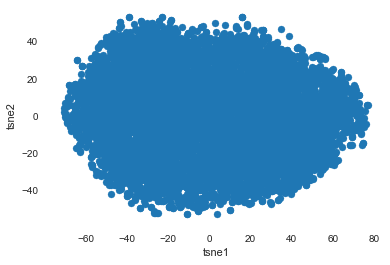

In [115]:
# 散布図の確認
print('< t-SNE data >')
plt.scatter(data_tsne[:,0], data_tsne[:,1])
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.show()

可視化のため、次元数を2としてt-SNEを使用した。  
しかし一つの塊となっており、サブグループに分割することは困難。

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


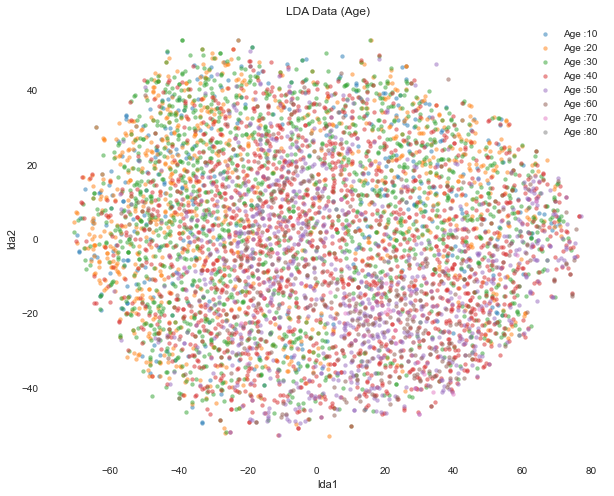

In [121]:
# 既知クラスタの散布図
age = y[:, np.newaxis]
age_tsne = np.hstack([age, data_tsne])
plt.figure(figsize=(10,8))
for i in range(1,9):
    data_i = data_tsne[np.where(age==i)[0]]
    plt.scatter(data_i[:, 0], data_i[:, 1], label='Age :{}'.format(i*10), s=15, alpha=0.5)
plt.title("LDA Data (Age)")
plt.xlabel('lda1')
plt.ylabel('lda2')
plt.legend() 

年齢を10代毎に区切り、10～80代の8つのグループでt-SNEの散布図を塗り分けてみたが、やはり意味のあるクラスタリングができているようには見えなかった。